In [1]:
import requests
import json
from tqdm.auto import tqdm
from collections import defaultdict
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from datetime import timedelta
from time import sleep

In [2]:

# Собираю id вакансий

from time import time


period = 14 #можно задать любой до 30 дней, взял 14 дней, получилось собрать более 2000 id


t = datetime.datetime.now()     # собираю вакансии с интервалом 15 мин от текущей даты t
delta = timedelta(hours=0.25)   # интервал в 15 минут
                                # даты в url перевожу в нужный формат isoforma()
t1 = t - delta
sber = '3529'






all_vacancy_ids = []
for i in tqdm(range(period*96)):

    url = f'https://api.hh.ru/vacancies?employer_id={sber}&date_to={t.isoformat()}&date_from={t1.isoformat()}'
    res = requests.get(url)
    vacancies = res.json()
    vacancy_ids = [el.get('id') for el in vacancies.get('items')]
    
    all_vacancy_ids.extend(vacancy_ids)
    if len(all_vacancy_ids) !=0 and len(all_vacancy_ids) % 100 == 0:
        res.close()
        sleep(10)

   # sleep(1)

    t = t1 + timedelta(hours=1/3600)
    t1 = t - timedelta(hours=0.25)

  0%|          | 0/1344 [00:00<?, ?it/s]

In [4]:
res.close()
sleep(15)

vacs = []
r = 1
for vac_id in tqdm(set(all_vacancy_ids)):       # здесь обернул словарь с id вакансий в set(), встречались повторяющиеся
    if r % 100 == 0:                            # возможно из-за округления временных интервалов
        sleep(5)
        res.close()
    url = f'https://api.hh.ru/vacancies/{vac_id}'
    res = requests.get(url)
    vacs.append(res.json())
    r +=1 


  0%|          | 0/2399 [00:00<?, ?it/s]

In [5]:
vacs_1 = vacs # на всякий случай сохранил

In [ ]:
#далее я оставил все, как это сделал 2 недели назад. в 3-м задании виден прогресс, даже моим невооруженным взглядом

In [7]:
vacs = pd.json_normalize(vacs)

In [8]:
vacs = vacs.drop(columns=['premium', 'relations', 'insider_interview',
       'response_letter_required', 'address', 'allow_messages', 'contacts',
        'branded_description', 'vacancy_constructor_template',
       'accept_handicapped', 'accept_kids', 'archived',
       'response_url', 'specializations', 'professional_roles', 'code',
       'hidden', 'quick_responses_allowed', 'driver_license_types',
       'accept_incomplete_resumes', 'created_at',
       'initial_created_at', 'negotiations_url', 'suitable_resumes_url',
       'apply_alternate_url', 'has_test', 'test', 'alternate_url',
       'working_days', 'working_time_intervals', 'working_time_modes',
       'accept_temporary', 'languages', 'billing_type.id', 'billing_type.name',
       'area.id', 'area.name', 'area.url', 'salary.from', 'salary.to',
       'salary.currency', 'salary.gross', 'type.id', 'type.name',
       'experience.id', 'experience.name', 'schedule.id', 'schedule.name',
       'employment.id', 'employment.name', 'department.id', 'department.name',
       'employer.id', 'employer.name', 'employer.url',
       'employer.alternate_url', 'employer.logo_urls.original',
       'employer.logo_urls.90', 'employer.logo_urls.240',
       'employer.vacancies_url', 'employer.trusted', 'address.city',
       'address.street', 'address.building', 'address.description',
       'address.lat', 'address.lng', 'address.raw',
       'address.metro.station_name', 'address.metro.line_name',
       'address.metro.station_id', 'address.metro.line_id',
       'address.metro.lat', 'address.metro.lng', 'address.metro_stations',
       'department', 'address.metro', 'immediate_redirect_url'])

In [10]:
vacs.tail()

,id,name,description,key_skills,published_at,salary
2394,68469571,Специалист по внутренним коммуникациям,<p>Кластер Методологии и Инструментов Тестиров...,"[{'name': 'Внутренние коммуникации'}, {'name':...",2022-08-04T11:06:35+0300,NaN
2395,68168792,Главный юрисконсульт в Сектор уголовно-процесс...,<p>Цель должности: методология вопросов примен...,[],2022-08-05T17:05:39+0300,NaN
2396,68575157,Старший клиентский менеджер,<p>Сбер — лучший работодатель России. У нас бо...,[],2022-08-08T15:54:55+0300,NaN
2397,68377818,Руководитель направления в Управление моделями,<strong>Обязанности:</strong> <ul> <li>Портфел...,"[{'name': 'Анализ рисков'}, {'name': 'Моделиро...",2022-08-02T09:37:42+0300,NaN
2398,68326202,Клиентский менеджер малого и микробизнеса,<p>Клиентский менеджер малого и микробизнеса –...,"[{'name': 'Активные продажи'}, {'name': 'Прове...",2022-08-01T09:56:27+0300,NaN


In [11]:
# Перевел дату в нужный формат

vacs.published_at = pd.to_datetime(vacs.published_at)

In [12]:
name = vacs.name
date = vacs.published_at

u = pd.concat([date, name], axis=1)
u.published_at = pd.to_numeric(u.published_at)

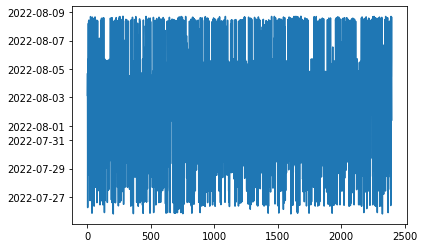

In [13]:
plt.plot(vacs['published_at'])

plt.show()

In [14]:
#здесь добавляю колонку с днями недели

# Перевожу в индексы с 0-6
vacs['weekday'] = vacs['published_at'].dt.dayofweek

# Передаю новые значения в словаре
test = vacs.replace({'weekday':{0:'Mo', 1:"Tu", 2:'We', 3:'Th', 4:'Fr', 5:'Sa', 6:'Sun'}})
test.weekday.unique()

array(['We', 'Th', 'Tu', 'Sun', 'Fr', 'Mo', 'Sa'], dtype=object)

In [15]:
# больше всего вакансий опубликовано в понедельник

test.groupby('weekday')['name'].count()

weekday
Fr     450
Mo     514
Sa      35
Sun     78
Th     456
Tu     377
We     489
Name: name, dtype: int64

In [16]:
from matplotlib.cbook import flatten


# это плод моего поиска решения, долго провозился, решил оставить

#Слайс по вакансиям с python

with_python = vacs.description.str.lower().str.contains('python'.lower())

best = vacs[with_python]

# Слайс по вакансиям аналитика
cool = best.name.str.lower().str.contains('аналитик'.lower())

# Здесь выборка аналитик с требованием python 


best = best[cool].reset_index()


# Здесь из получившихся данных достаю скилы
i = 0
l = []
for i in range(len(best.key_skills)):
    l.append([x.get('name') for x in best.key_skills[i]])
    i += 1

# Тут я совсем сломал голову, создал общий список, далее удалил дубли и создал словарь
l = list(flatten(l))
l_u = set(l)

d = {'skills':[], 'position':[]}

# здесь считаю количество повторений, создаю словарь
for i in l_u:
    d['skills'].append(i)
    d['position'].append(l.count(i))
# из словаря получился DataFrame

d = pd.DataFrame(d)

<AxesSubplot:xlabel='skills'>

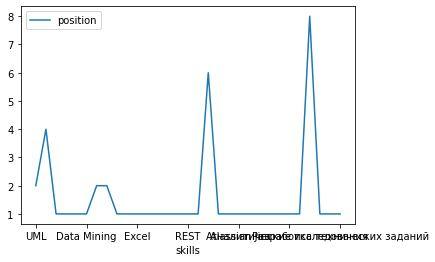

In [17]:
d.plot(x = 'skills' , y = 'position')